This is a PyQt5-based GUI application that allows users to view and interact with GeoTIFF images (geospatial raster images). The application enables zooming, panning, marking locations, and converting between pixel and geographic coordinates (latitude/longitude).

# **Dependencies**
1. **sys** → System-related functionalities
2. **numpy** → Numerical computations
3. **gdal** (from osgeo) → Geospatial data processing
4. **matplotlib.pyplot** → Data visualization
5. **PyQt5.QtWidgets** → GUI components
6. **PyQt5.QtCore** → Core functionalities for PyQt5
7. **FigureCanvasQTAgg** → Embeds Matplotlib figures in PyQt5 GUI








In [1]:
import sys
import numpy as np
from osgeo import gdal
import matplotlib.pyplot as plt
from PyQt5.QtWidgets import QApplication, QMainWindow, QLabel, QPushButton, QVBoxLayout, QWidget, QLineEdit, QHBoxLayout
from PyQt5.QtCore import Qt
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas

# Key Features and Functionalities
1. **Load and Display GeoTIFF Images**

Uses gdal.Open(self.tif_file) to load a GeoTIFF image.
Reads the image into a NumPy array and handles multi-band (RGB) images.
Displays the image using matplotlib.

2. **Coordinate Conversion**

pixel_to_latlon(x, y): Converts pixel coordinates to latitude/longitude using the GeoTransform matrix.
latlon_to_pixel(lat, lon): Converts geographic coordinates back to pixel coordinates using the inverse GeoTransform.

3. **Mouse Tracking**

The on_mouse_move(event) function updates the X, Y, latitude, and longitude values when the user moves the mouse over the image.

4. **Marking Locations**

The user can enter latitude and longitude, and the application marks the location on the image with a red + symbol.

5. **Zooming and Panning**

Zooming: on_scroll(event) adjusts the zoom level using the mouse wheel.
Panning: The user can click and drag to move around the image.

6. **PyQt5 UI Setup**

Uses QMainWindow, QLabel, QLineEdit, QPushButton, and QVBoxLayout for the UI.
Displays the image using matplotlib's FigureCanvas inside the PyQt5 window.
Workflow of the Application.

7. **Initialize the Viewer**

Load the GeoTIFF file and extract its GeoTransform matrix.
Convert multi-band images to RGB if needed.

8. **Set Up the UI**

Create a main display for the image.
Add labels for displaying coordinates.
Provide input fields for latitude/longitude marking.

9. **Enable Mouse Interactions**

Track the mouse position and update the UI dynamically.
Allow zooming via scroll events.
Implement panning using click-and-drag.

10. **Allow User to Mark Locations**

Convert latitude/longitude to pixel coordinates.
Plot the point on the image using matplotlib.

11. **Redraw the Canvas**

Update the display whenever an interaction occurs (zoom, pan, mark).


In [2]:

class GeoTIFFViewer(QMainWindow):
    """
    A PyQt5-based GUI application for viewing and interacting with GeoTIFF images.
    This includes displaying the image, tracking pixel coordinates, converting to
    latitude/longitude, marking specific locations, and supporting zoom/pan functionality.
    """
    def __init__(self, tif_file):
        """Initialize the GeoTIFF Viewer."""
        super().__init__()
        self.tif_file = tif_file
        self.dataset = gdal.Open(self.tif_file)  # Load GeoTIFF file
        self.geotransform = self.dataset.GetGeoTransform()
        self.image = self.dataset.ReadAsArray()

        # Convert multi-band images to displayable format (RGB)
        if len(self.image.shape) == 3:
            self.image = np.transpose(self.image, (1, 2, 0))

        self.initUI()

    def initUI(self):
        """Setup UI layout and elements."""
        self.setWindowTitle("GeoTIFF Viewer")
        self.setGeometry(100, 100, 900, 700)

        # Create a matplotlib canvas for displaying the image
        self.canvas = FigureCanvas(plt.figure(figsize=(6, 6)))
        self.ax = self.canvas.figure.add_subplot(111)
        self.ax.imshow(self.image, cmap='gray')

        # Labels for displaying pixel and geographical coordinates
        self.x_label, self.y_label = QLabel("X: N/A"), QLabel("Y: N/A")
        self.lat_label, self.lon_label = QLabel("Latitude: N/A"), QLabel("Longitude: N/A")

        # Input fields for latitude & longitude marking
        self.lat_input, self.lon_input = QLineEdit(), QLineEdit()
        self.lat_input.setPlaceholderText("Enter Latitude")
        self.lon_input.setPlaceholderText("Enter Longitude")
        self.mark_button = QPushButton("Mark Location")
        self.mark_button.clicked.connect(self.mark_location)

        # Layout for coordinate display
        coord_layout = QHBoxLayout()
        for label in [self.x_label, self.y_label, self.lat_label, self.lon_label]:
            coord_layout.addWidget(label)

        # Layout for user input (Latitude, Longitude, Mark Button)
        input_layout = QHBoxLayout()
        for widget in [self.lat_input, self.lon_input, self.mark_button]:
            input_layout.addWidget(widget)

        # Main layout
        main_layout = QVBoxLayout()
        main_layout.addWidget(self.canvas)
        main_layout.addLayout(coord_layout)
        main_layout.addLayout(input_layout)

        # Set the layout to the central widget
        container = QWidget()
        container.setLayout(main_layout)
        self.setCentralWidget(container)

        # Connect mouse events for tracking and interactivity
        self.canvas.mpl_connect("motion_notify_event", self.on_mouse_move)
        self.canvas.mpl_connect("scroll_event", self.on_scroll)
        self.canvas.mpl_connect("button_press_event", self.on_mouse_press)
        self.canvas.mpl_connect("button_release_event", self.on_mouse_release)
        self.canvas.mpl_connect("motion_notify_event", self.on_mouse_drag)

        # Variables for zooming and panning
        self.pan_start = None
        self.zoom_factor = 1.0

    def pixel_to_latlon(self, x, y):
        """Convert pixel (X, Y) coordinates to geographic (latitude, longitude)."""
        lon = self.geotransform[0] + x * self.geotransform[1] + y * self.geotransform[2]
        lat = self.geotransform[3] + x * self.geotransform[4] + y * self.geotransform[5]
        return lat, lon

    def latlon_to_pixel(self, lat, lon):
        """Convert latitude & longitude to pixel (X, Y) coordinates."""
        inv_transform = gdal.InvGeoTransform(self.geotransform)
        px, py = gdal.ApplyGeoTransform(inv_transform, lon, lat)
        return int(px), int(py)

    def on_mouse_move(self, event):
        """Update X, Y, Latitude, and Longitude as the mouse moves over the image."""
        if event.xdata is not None and event.ydata is not None:
            lat, lon = self.pixel_to_latlon(event.xdata, event.ydata)
            self.x_label.setText(f"X: {int(event.xdata)}")
            self.y_label.setText(f"Y: {int(event.ydata)}")
            self.lat_label.setText(f"Latitude: {lat:.6f}")
            self.lon_label.setText(f"Longitude: {lon:.6f}")

    def mark_location(self):
        """Mark a specific location on the image based on user-entered latitude and longitude."""
        try:
            lat, lon = float(self.lat_input.text()), float(self.lon_input.text())
            px, py = self.latlon_to_pixel(lat, lon)
            self.ax.plot(px, py, marker='+', color='red', markersize=12)
            self.canvas.draw()
        except ValueError:
            print("Invalid latitude/longitude input!")

    def on_scroll(self, event):
        """Zoom functionality using the mouse wheel."""
        if event.step > 0:
            self.zoom_factor *= 1.2  # Zoom in
        else:
            self.zoom_factor /= 1.2  # Zoom out

        self.ax.set_xlim(self.ax.get_xlim()[0] / self.zoom_factor, self.ax.get_xlim()[1] / self.zoom_factor)
        self.ax.set_ylim(self.ax.get_ylim()[0] / self.zoom_factor, self.ax.get_ylim()[1] / self.zoom_factor)
        self.canvas.draw()

    def on_mouse_press(self, event):
        """Capture the starting point for panning when the left mouse button is pressed."""
        if event.button == 1:
            self.pan_start = (event.xdata, event.ydata)

    def on_mouse_release(self, event):
        """Reset panning state when the mouse button is released."""
        self.pan_start = None

    def on_mouse_drag(self, event):
        """Enable panning by dragging the image."""
        if self.pan_start is None or event.xdata is None or event.ydata is None:
            return
        dx, dy = event.xdata - self.pan_start[0], event.ydata - self.pan_start[1]

        self.ax.set_xlim(self.ax.get_xlim()[0] - dx, self.ax.get_xlim()[1] - dx)
        self.ax.set_ylim(self.ax.get_ylim()[0] - dy, self.ax.get_ylim()[1] - dy)
        self.canvas.draw()
        self.pan_start = (event.xdata, event.ydata)


c:\Users\qures\anaconda3\Lib\site-packages\osgeo\gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


SystemExit: 0

c:\Users\qures\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


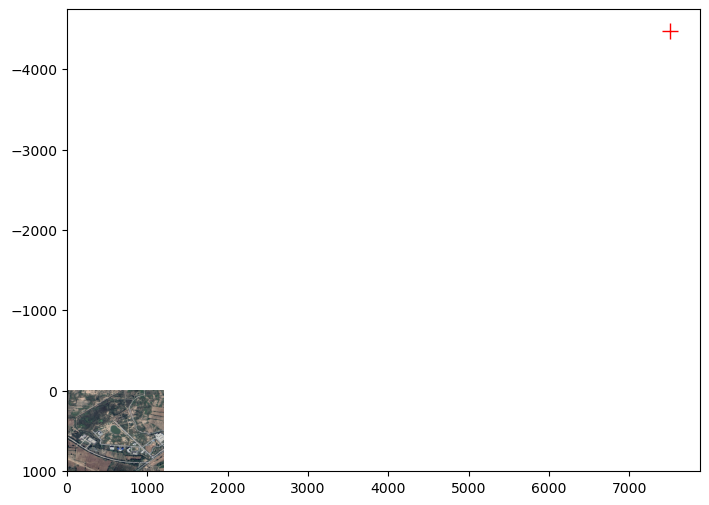

In [3]:
if __name__ == "__main__":
    app = QApplication(sys.argv)
    window = GeoTIFFViewer(r"E:\Computer Vision\Working with GeoTIFF Images Using GDAL\testGeoTiff.tif")
    window.show()
    sys.exit(app.exec_())